In [51]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import time


# hand made functions
sys.path.insert(1, '../../Modeles3D/test_3D/')
from Rouss3D import *

sys.path.insert(1, '../../Modeles2D/test_premier_model/')
from Rouss1 import *
from Rouss2 import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

sys.path.insert(1, '../../Modeles2D/Raffinement/')
from Rouss_uns import *

In [52]:
def nn2kij(n,nlay,nrow,ncol):
    """
    from a node number to ilay,irow and icol (dis)
    """
    return fp.utils.gridintersect.ModflowGridIndices.kij_from_nn0(n,nlay,nrow,ncol)

In [53]:
model_dir = "working"
model_name = "2etest_3D"
exe_name= "../../exe/mf6"

In [54]:
R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
Q_path = "../../data/shp/entités/Q_merge.shp"
P_path = "../../data/shp/entités/Plio_merge.shp"

#rivers paths
Agly_path = "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path = "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

#stations paths
Agly_stations = "../../data/Fleuves/stations_agly.csv" 
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"

In [55]:
#spatial parameters

MNT_path = "../../data/MNT/MNT_50.tif"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

Lx = x1-x0
Ly = y1-y0
nlay = 3
res = 300
botm=0
ncol = int(Lx/res)
nrow = int(Ly/res)

delr = np.ones(ncol)*res
delc = np.ones(nrow)*res

idomain = np.zeros(([nlay,nrow,ncol]))

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data

In [56]:
# top
Rast = Raster.load(MNT_path)
top = Rast.resample_to_grid(grid.xcellcenters,
                      grid.ycellcenters,
                      band = Rast.bands[0],
                      method="nearest")

In [57]:
# create fakesimulation
sim_f = fp.mf6.MFSimulation(sim_name='fake_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)

# create gwf model
gwf_f = fp.mf6.ModflowGwf(sim_f, modelname="model_name",
                           model_nam_file='{}.nam'.format(model_name))

dis_f = fp.mf6.ModflowGwfdis(gwf_f,nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,xorigin=x0,yorigin=y0)

g = Gridgen(dis_f,exe_name="../../exe/Gridgen.exe")
g.build()

In [58]:
shp_path="../../data/shp/entités/Q_merge"
shp2idomain(shp_path,g,idomain)
shp_path="../../data/shp/entités/Plio_merge"
shp2idomain(shp_path,g,idomain,layer=1)

C:\Users\emmal\Anaconda3\lib\site-packages\flopy\utils\gridgen.py:1552: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  usecols=tuple(range(ncol)))


In [59]:
# with gridintersect, much slower

#Q_IDs = gp2cellids3D(grid,gp.read_file(Q_path),idomain,layer=0)
#Pl_IDs = gp2cellids3D(grid,gp.read_file(P_path),idomain,layer=1)

In [60]:
idomain[2] = idomain[1] # same extent for PMS than PC

In [61]:
botm = np.ones([nlay,nrow,ncol])

# surfaces synthethiques

#Q
botm[0] = top.copy()
botm[0][idomain[0]==1] = top[idomain[0]==1] - 10
botm[0][idomain[0]!=1] -= 1

In [62]:
#tentative d'une meilleure dis

#Q
surf = Raster.load("../../data/txt_couches_nouv/s2_mur_quat.txt")
botm[0] = surf.resample_to_grid(grid.xcellcenters,
                      grid.ycellcenters,
                      band = surf.bands[0],
                      method="nearest")
mask = (botm[0]==-9999) & (idomain[0]==1)
botm[0][mask]=top[mask]-10 # épaisseur minimale de 10


#PC
surf = Raster.load("../../data/txt_couches_nouv/s3_mur_pc.txt")
botm[1] = surf.resample_to_grid(grid.xcellcenters,
                      grid.ycellcenters,
                      band = surf.bands[0],
                      method="nearest")
mask = (botm[1]==-9999) & (idomain[1]==1)
botm[1][mask]=botm[0][mask]-5 # épaisseur minimale de 10

#PMS
surf = Raster.load("../../data/txt_couches_nouv/s4_mur_pms.txt")
botm[2] = surf.resample_to_grid(grid.xcellcenters,
                      grid.ycellcenters,
                      band = surf.bands[0],
                      method="nearest")
mask = (botm[2]==-9999) & (idomain[2]==1)
botm[2][mask]=botm[1][mask]-10

In [63]:
# attribute a minimum thickness 
MinThick(idomain,botm,top)

In [64]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))

In [65]:
#uppermost active cells
Up_cells_act = up_act_cell(idomain)

In [66]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="line",idomain_active=True)

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [67]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.SHP"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True)

# attribute a constant head
CHD = 0; et_chd_lst=[];
for x in etangs_chd:
    et_chd_lst.append((x,CHD))
    lst_chd.append(x)

In [68]:
Agy_chd = Complete_riv(Agly_path,Agly_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tech_chd = Complete_riv(Tech_path,Tech_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Cant_chd = Complete_riv(Cant_path,Cant_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Rea_chd = Complete_riv(Rea_path,Rea_stations,100,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tet_chd = Complete_riv(Tet_path,Tet_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Bol_chd = Complete_riv(Bol_path,Bol_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [69]:
# extraction
path = "../../data/prélèvements/BD_FORAGES_SMNPR/SMNPRV2.shp"

stress_data_well = importWells3D(path,grid,lst_domain,V_col="V_A_AEMRC", geol_col="NAPPE_CAPT",
                                 geol_layer=["PLIOCENE","QUATERNAIRE"],layer_num=[1,0])

In [70]:
# perma
K = np.ones([nlay,nrow,ncol])*1e-4
K[0] = 1e-4
K[1] = 1e-5
K[2] = 5e-5
K = K.reshape(nlay*nrow*ncol)

# we can add zones (based on points --> can be manual input or shp import, just need to pre-process data as in the example)
# define a zone 
z1 = [[[(678e3,615.2e4),(689e3,616e4),(695e3,616.1e4),(700e3,616.1e4),(700e3,615.2e4)]]]

assign_k_zones(z1,5e-5,K,g,0)
assign_k_zones(z1,5e-6,K,g,1)
assign_k_zones(z1,5e-6,K,g,2)

In [71]:
# Rajout de BC en bordure
BDcells = cellidBD(idomain,layer=1) # extraction des cells en bordure
z2 = [[[(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)]]] # dans quelle zone

plio_chd=[]
res = g.intersect(z2,"polygon",1)
for i in res.nodenumber:
    if nn2kij(i,nlay,nrow,ncol) in BDcells: # check les cellules de la zone ET en bordure
        plio_chd.append(((nn2kij(i,nlay,nrow,ncol)),115))      

In [72]:
piez_path="../../data/piezos/pz_hydriad.xlsx"
Control_Pz = ImportControlPz3D(piez_path,sheet_name="1960",geol_layer=["Quaternaire","Pliocène"],layer_num=[0,1],geol_col="AquifèreCapté",
                 grid=grid,nlay=nlay)

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [73]:
#recharge
rch_path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch(rch_path,grid,coeff=0.6)

rch_lst=[]
for icell in Up_cells_act:
    ilay = icell[0]
    irow = icell[1]
    icol = icell[2]
    rch_lst.append(((icell),rcha[irow,icol]/1000/365/86400))
            

In [74]:
# drains everywhere

drn_areas=inter_lst(Up_cells_act,lst_chd,typ="unique")
lst_drn=[]
for cellid in drn_areas:
    i = cellid[0]
    j = cellid[1]
    k = cellid[2]
    
    xc = grid.xcellcenters[j,k]
    yc = grid.ycellcenters[j,k]
    
    lst_drn.append(((i,j,k),top[j,k]-1,0.01))

In [75]:
# basic modules

sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='moderate')


# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)


# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])


# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=K, save_flows=True,save_specific_discharge=True)


# recharge
#rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400)
rch = fp.mf6.ModflowGwfrch(gwf,maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)


#drain
#drn = fp.mf6.ModflowGwfdrn(gwf,pname="sup_flow",maxbound=len(lst_drn),stress_period_data=lst_drn)

#well
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(stress_data_well),
                           stress_period_data=stress_data_well,save_flows=True)

#chd
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

plio = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='plio', filename="plio.chd", maxbound=len(plio_chd), 
                                               stress_period_data={0: plio_chd}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Cant', filename="Cant.chd", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Bol', filename="Bol.chd", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)


In [76]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model 2etest_3D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rch_0...
    writing package wel...
    writing package sea...
    writing package plio...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Althou

(True, [])

In [77]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

# retrieve the chd package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

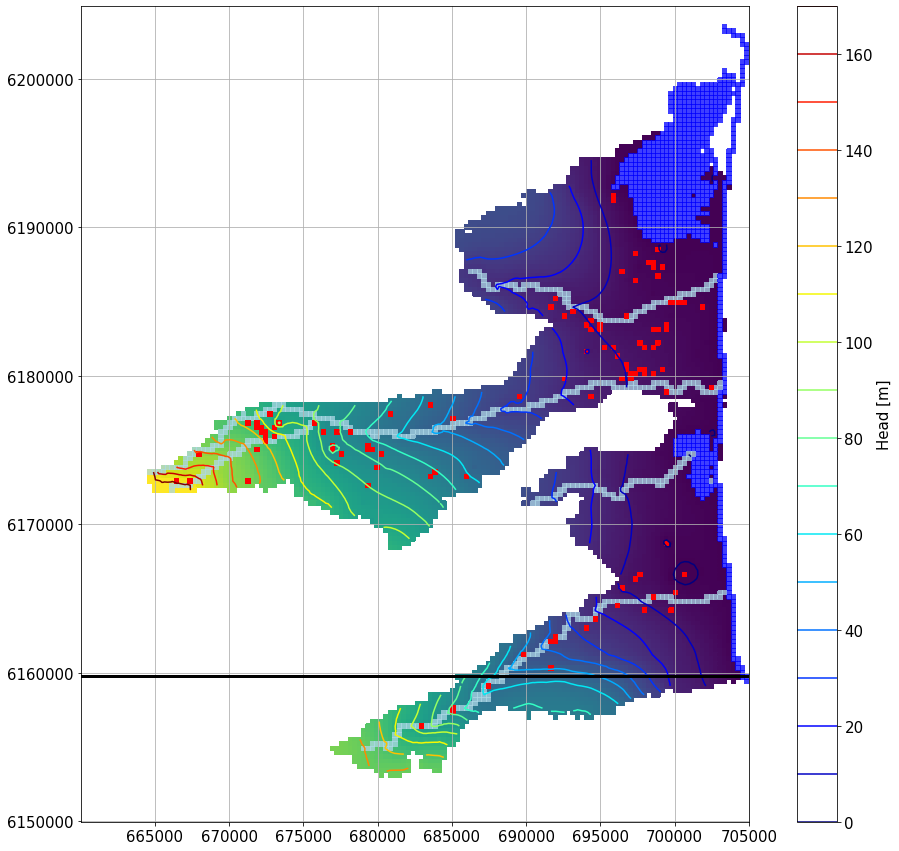

In [78]:
# make a plot
layer = 0
fig = plt.figure(figsize=(17,15))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)



hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
cont=ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),cmap="jet")

# plot bc
for bc in bdfile:
    if bc == ("sea") or bc== ("eta"):
        ml.plot_bc(bc,color="b",alpha=0.5)
    else : 
        ml.plot_bc(bc,color="lightblue",alpha=0.5)
ml.plot_bc("wel")

# plot Cross-section
row = 150
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)


ax.tick_params(labelsize=15)
#ax.tick_params(axis="y",direction="in", pad=-120)

g1 = plt.colorbar(cont)
g1.set_label("Head [m]",fontsize=15)
g1.ax.tick_params(labelsize=15)

ax.grid()


(-200, 400)

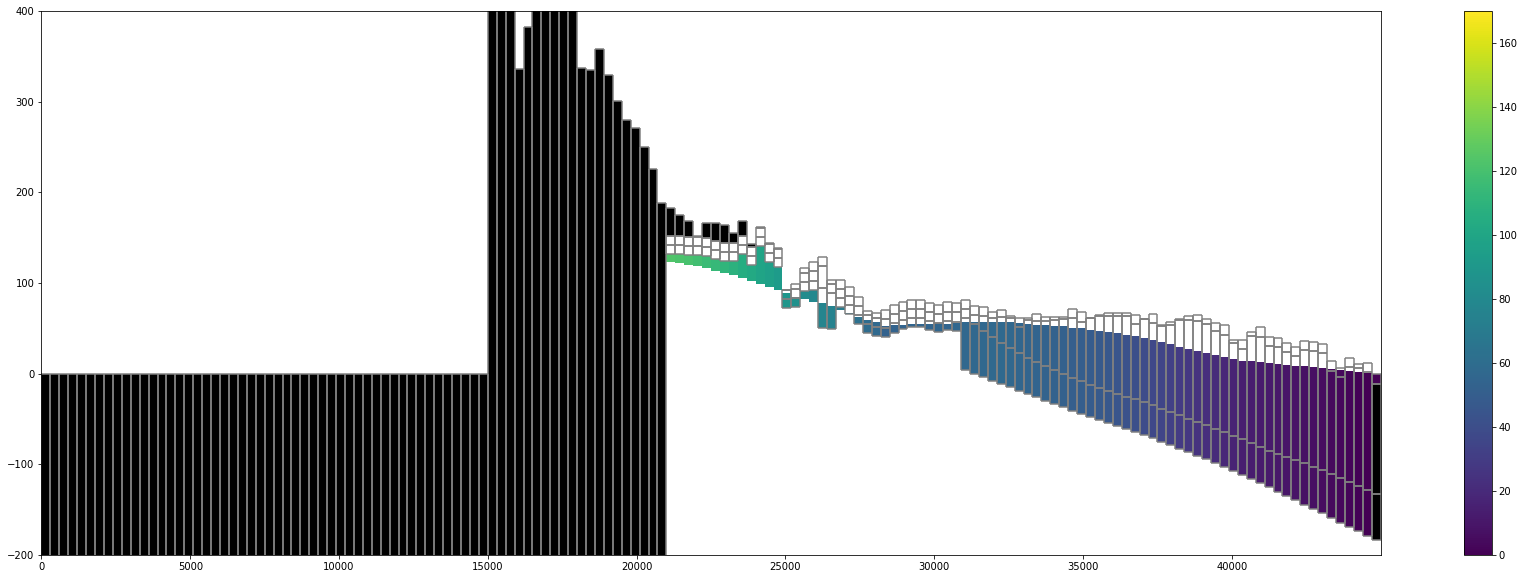

In [79]:
fig,ax = plt.subplots(figsize=(30,10))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax.set_ylim(-200,400)

In [80]:
# Total Budget
lstBudgetfile = "{}.lst".format(model_name)
fname = os.path.join(model_dir,lstBudgetfile)
Budgetobj = fp.utils.Mf6ListBudget(fname)

for i in Budgetobj.entries:
    if i != "PERCENT_DISCREPANCY":
        print("{} : {} m3/s".format(i,Budgetobj.get_budget(names=i)[0][0][-1]))

WEL_IN : 0.0 m3/s
RCH_IN : 2.9298999309539795 m3/s
CHD_IN : 0.3255999982357025 m3/s
TOTAL_IN : 3.9900999069213867 m3/s
WEL_OUT : 1.409600019454956 m3/s
RCH_OUT : 0.0 m3/s
CHD_OUT : 0.04402099922299385 m3/s
TOTAL_OUT : 3.9899001121520996 m3/s
IN-OUT : 0.00019778999558184296 m3/s


In [81]:
Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head = head.reshape(nlay*nrow*ncol)

Text(0.5, 1.0, 'fit measured vs simulated')

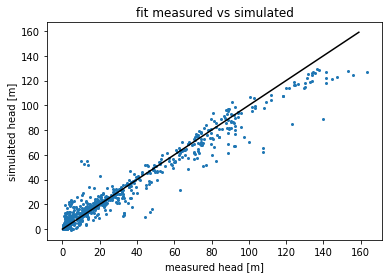

In [82]:
head[head>1000]=None
plt.scatter(Control_pz[Control_pz!=0],
            head[Control_pz!=0],s=4)
plt.plot(np.arange(160),np.arange(160),"k")
plt.xlabel("measured head [m]")
plt.ylabel("simulated head [m]")
plt.title("fit measured vs simulated")

In [83]:
Misfit = np.abs((Control_pz[Control_pz!=0] - head[Control_pz!=0]))
print("Misfit : {} m ".format(np.nanmean(Misfit)))

Misfit : 5.021858657365556 m 


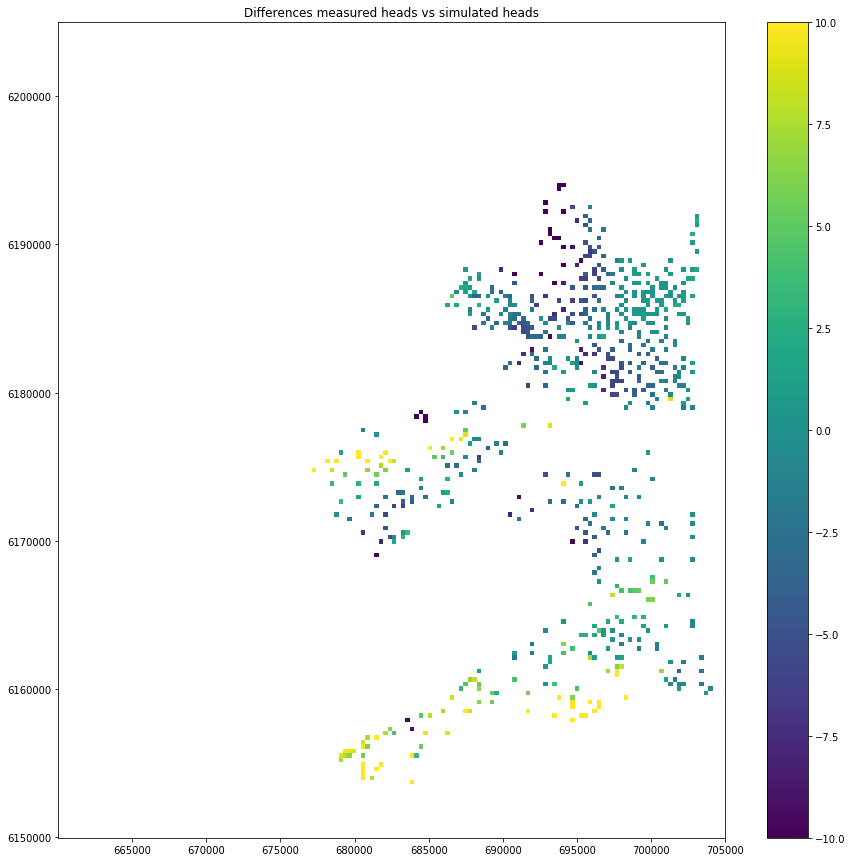

In [84]:
head[Control_pz==0]=None
fig,ax=plt.subplots(figsize=(15,15))
a=plt.imshow((Control_pz - head).reshape(nlay,nrow,ncol)[0],extent=[x0,x1,y0,y1])
plt.title("Differences measured heads vs simulated heads")
plt.colorbar()
ecart = 10
a.set_clim(-ecart,ecart)